In [1]:
%pip install torchinfo

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
from torchvision import transforms, utils
import matplotlib.pyplot as plt
from PIL import Image
import os
import pandas as pd
import numpy as np
import torch.nn as nn
from torchinfo import summary
from sklearn.model_selection import GridSearchCV
from skorch import NeuralNetClassifier


In [3]:
path = './MURA-v1.1/'
train_image_paths_csv = "train_image_paths.csv"
df_train_images_paths = pd.read_csv(os.path.join(path,train_image_paths_csv),dtype=str,header=None)
df_train_images_paths.columns = ['image_path']

In [4]:
df_train_images_paths['label'] = df_train_images_paths['image_path'].map(lambda x: 'positive' if 'positive' in x else 'negative')
df_train_images_paths['category'] = df_train_images_paths['image_path'].apply(lambda x: x.split('/')[2])
#df_train_images_paths['patientId'] = df_train_images_paths['image_path'].apply(lambda x: x.split('/')[3].replace('patient',''))

In [5]:
valid_image_paths_csv = "valid_image_paths.csv"
df_valid_data_paths = pd.read_csv(os.path.join(path,valid_image_paths_csv),dtype=str,header=None)
df_valid_data_paths.columns = ['image_path']

In [7]:
df_valid_data_paths['label'] = df_valid_data_paths['image_path'].map(lambda x:'positive' if 'positive' in x else 'negative')
df_valid_data_paths['category']  = df_valid_data_paths['image_path'].apply(lambda x: x.split('/')[2])
#df_valid_data_paths['dir'] =  df_valid_data_paths['image_path'].apply(lambda x: x.split('/')[1])
#df_valid_data_paths['patientId']  = df_valid_data_paths['image_path'].apply(lambda x: x.split('/')[3].replace('patient',''))

In [8]:
df_train_images_paths["label"] = df_train_images_paths["label"].replace({'positive': 1, 'negative': 0})


In [9]:
df_valid_data_paths["label"] = df_valid_data_paths["label"].replace({'positive': 1, 'negative': 0})


# ResNet 50

In [10]:
import torchvision.models as models

resnet50 = models.resnet50(pretrained=False)

c:\Users\Hamad\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Hamad\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


# DataLoader

In [12]:
from skimage.filters import butterworth
from skimage.filters import gaussian
from skimage import exposure



In [13]:
from torch.utils.data import Dataset
from skimage import img_as_ubyte
from skimage.color import rgb2gray
class MuraDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None, device='cpu'):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.device = device

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.item()
        
        img_path = self.image_paths[idx]
        image = Image.open(img_path)
        image = image.convert('RGB')
        
        # Convert PIL Image to numpy array
        image_np = np.array(image)
        
        image_gray = rgb2gray(image_np)
        
        # Apply adaptive histogram equalization
        image_gray = exposure.equalize_adapthist(image_gray, clip_limit=0.02)

        
        # Apply Butterworth filter
        image_butterworth = butterworth(image_gray)

        
        # Apply Gaussian filter
        image_gaussian = gaussian(image_gray)
        
        # Combine the two images into one (stack them along the last axis)
        # Create a 3 channel image from the butterworth and gaussian filtered images
        image_combined = np.stack([image_butterworth, image_gaussian, image_gray], axis=-1)
        
        image_combined = (image_combined - np.min(image_combined)) / (np.max(image_combined) - np.min(image_combined))
        
        # Convert to 8-bit image for PIL
        image_combined = img_as_ubyte(image_combined)
        
        # Convert numpy array back to PIL Image
        image = Image.fromarray(image_combined)
        
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        image = image.to(self.device)
        
        label = torch.tensor(label).to(self.device)

        return image, label


In [14]:
from torch.utils.data import DataLoader
from torchvision.transforms import v2

batchsize = 8
transform = transforms.Compose([
    v2.RandomHorizontalFlip(p=0.5),
    v2.Resize((224, 224)),
    v2.ToTensor(),
])

val_transform = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToTensor(),
])

Mura_transform = MuraDataset(df_train_images_paths["image_path"], df_train_images_paths["label"], transform=transform,device='cuda')
train_loader = DataLoader(Mura_transform, batch_size=batchsize, shuffle=True)
Mura_transform_valid = MuraDataset(df_valid_data_paths["image_path"], df_valid_data_paths["label"], transform=val_transform,device='cuda')
valid_loader = DataLoader(Mura_transform_valid, batch_size=batchsize)



c:\Users\Hamad\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
c:\Users\Hamad\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedba

Feature batch shape: torch.Size([8, 3, 224, 224])
Labels batch shape: torch.Size([8])


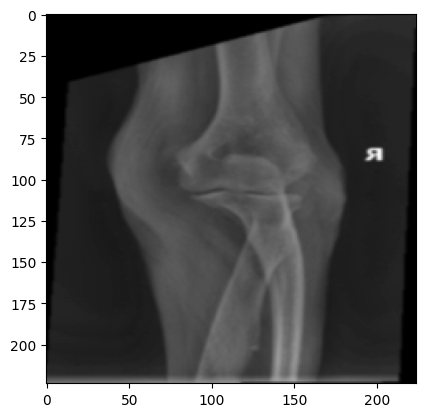

Label: 1


In [17]:
# Display image and label.
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

# Select a single image from the batch.
img = train_features[0]

# Select one channel (e.g., the first channel).
img_channel1 = img[1].cpu().numpy()

# Display the selected channel.
plt.imshow(img_channel1, cmap="gray")
plt.show()

# Alternatively, you can display the second channel
# img_channel2 = img[1].cpu().numpy()
# plt.imshow(img_channel2, cmap="gray")
# plt.show()

label = train_labels[0]
print(f"Label: {label}")


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [19]:
summary(resnet50, input_size=(8, 3, 224, 224))


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [8, 1000]                 --
├─Conv2d: 1-1                            [8, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [8, 64, 112, 112]         128
├─ReLU: 1-3                              [8, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [8, 64, 56, 56]           --
├─Sequential: 1-5                        [8, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [8, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [8, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [8, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [8, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [8, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [8, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [8, 64, 56, 56]           --
│ 

In [20]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet50.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)

In [24]:
num_ftrs = resnet50.fc.in_features 
resnet50.fc = torch.nn.Linear(num_ftrs, 2)  

In [25]:
summary(resnet50, input_size=(8, 3, 224, 224))


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [8, 2]                    --
├─Conv2d: 1-1                            [8, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [8, 64, 112, 112]         128
├─ReLU: 1-3                              [8, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [8, 64, 56, 56]           --
├─Sequential: 1-5                        [8, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [8, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [8, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [8, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [8, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [8, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [8, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [8, 64, 56, 56]           --
│ 

In [28]:
resnet50.to(device=device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [29]:
num_epochs = 10

for epoch in range(num_epochs):
    resnet50.train()
    total_loss = 0.0
    correct = 0  # To keep track of correct predictions
    total = 0  # To keep track of total predictions

    batch_accuracies = []  # To store batch accuracies for the epoch

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet50(images)

        loss = criterion(outputs, labels) 
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        
        _, predicted = outputs.max(1)  # Get the index of the max log-probability
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Print loss and accuracy for every 100 batches
        if (batch_idx + 1) % 100 == 0:
            batch_accuracy = 100. * correct / total
            batch_accuracies.append(batch_accuracy)  # Store the batch accuracy
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Batch Loss: {loss.item():.4f}, Batch Accuracy: {batch_accuracy:.2f}%")
    scheduler.step()
    avg_loss = total_loss / len(train_loader)
    epoch_accuracy = 100. * correct / total  # Convert to percentage

    # Calculate the average of batch accuracies for the epoch
    avg_batch_accuracy = sum(batch_accuracies) / len(batch_accuracies) if batch_accuracies else 0.0

    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}, Epoch Accuracy: {epoch_accuracy:.2f}%, Average Batch Accuracy: {avg_batch_accuracy:.2f}%")


Epoch [1/10], Batch [100/4601], Batch Loss: 0.6942, Batch Accuracy: 57.75%
Epoch [1/10], Batch [200/4601], Batch Loss: 0.6679, Batch Accuracy: 60.06%
Epoch [1/10], Batch [300/4601], Batch Loss: 0.8790, Batch Accuracy: 61.33%
Epoch [1/10], Batch [400/4601], Batch Loss: 0.5509, Batch Accuracy: 61.25%
Epoch [1/10], Batch [500/4601], Batch Loss: 0.7776, Batch Accuracy: 61.50%
Epoch [1/10], Batch [600/4601], Batch Loss: 0.4854, Batch Accuracy: 61.52%
Epoch [1/10], Batch [700/4601], Batch Loss: 0.4555, Batch Accuracy: 61.52%
Epoch [1/10], Batch [800/4601], Batch Loss: 0.6630, Batch Accuracy: 61.05%
Epoch [1/10], Batch [900/4601], Batch Loss: 0.7221, Batch Accuracy: 61.46%
Epoch [1/10], Batch [1000/4601], Batch Loss: 0.7074, Batch Accuracy: 61.62%
Epoch [1/10], Batch [1100/4601], Batch Loss: 0.6037, Batch Accuracy: 61.66%
Epoch [1/10], Batch [1200/4601], Batch Loss: 0.5917, Batch Accuracy: 61.43%
Epoch [1/10], Batch [1300/4601], Batch Loss: 0.5650, Batch Accuracy: 61.43%
Epoch [1/10], Batch [

In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Switch the model to evaluation mode
resnet50.eval()

# Initialize lists to store all true labels and all predictions
all_labels = []
all_predictions = []    

# Disabling gradient calculation
with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(valid_loader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = resnet50(images)  
        

        # Get predictions
        _, predicted = outputs.max(1)

        # Store predictions and true labels for later calculation of metrics
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Print status for every 50 batches (or another number if you prefer)
        if (batch_idx + 1) % 100 == 0:
            print(f"Test Batch [{batch_idx+1}/{len(valid_loader)}] Processed")


# Compute metrics
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)  # Using weighted average if you have class imbalance
recall = recall_score(all_labels, all_predictions)  # Using weighted average if you have class imbalance
f1 = f1_score(all_labels, all_predictions)  # Using weighted average if you have class imbalance


print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1-Score: {f1:.4f}")



Test Batch [100/400] Processed
Test Batch [200/400] Processed
Test Batch [300/400] Processed
Test Batch [400/400] Processed
Test Accuracy: 0.6584
Test Precision: 0.6758
Test Recall: 0.5503
Test F1-Score: 0.6066


In [ ]:
import torch
save_path = './RESNET_mura_phase_3_10epoch.pth'
torch.save(resnet50,save_path)